Epoch [10/100], Train Loss: 0.6642, Test Loss: 0.6584
Epoch [20/100], Train Loss: 0.5954, Test Loss: 0.5854
Epoch [30/100], Train Loss: 0.5191, Test Loss: 0.5029
Epoch [40/100], Train Loss: 0.4377, Test Loss: 0.4151
Epoch [50/100], Train Loss: 0.3597, Test Loss: 0.3319
Epoch [60/100], Train Loss: 0.2932, Test Loss: 0.2615
Epoch [70/100], Train Loss: 0.2414, Test Loss: 0.2064
Epoch [80/100], Train Loss: 0.2028, Test Loss: 0.1647
Epoch [90/100], Train Loss: 0.1743, Test Loss: 0.1336
Epoch [100/100], Train Loss: 0.1534, Test Loss: 0.1106


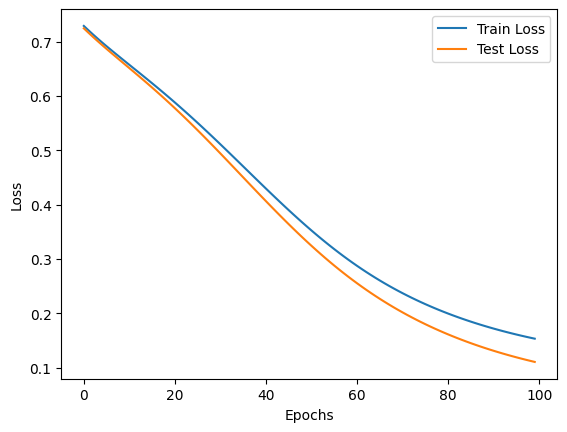

Accuracy: 0.9825
F1 Score: 0.9825
Precision: 0.9833
Recall: 0.9825
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import flask
from flask import request, jsonify, send_file

# Load dataset (replace this with your dataset)
data = pd.read_csv('/content/wisc_bc_data.csv')  # Replace 'your_dataset.csv' with your dataset file path

# Ensure there are no NaN values
data = data.dropna()

# Encode the target column if it's categorical
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])  # Replace 'diagnosis' with actual target column name

# Split into features and labels
X = data.drop('diagnosis', axis=1).values  # Replace 'diagnosis' with actual target column name
y = data['diagnosis'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.astype(np.int64))  # Ensure target labels are integers
y_test_tensor = torch.LongTensor(y_test.astype(np.int64))

# Define the Ada-Act activation function
class AdaAct(nn.Module):
    def __init__(self):
        super(AdaAct, self).__init__()
        # Initialize k0 and k1 as learnable parameters
        self.k0 = nn.Parameter(torch.randn(1))
        self.k1 = nn.Parameter(torch.randn(1))

    def forward(self, x):
        # Define the Ada-Act function: g(x) = k0 + k1 * x
        return self.k0 + self.k1 * x

# Define the Neural Network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ada_act1 = AdaAct()  # Apply Ada-Act activation after the first layer
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward propagation
        out = self.fc1(x)
        out = self.ada_act1(out)  # Apply Ada-Act activation function
        out = self.fc2(out)
        return out

# Define model parameters
input_size = X_train.shape[1]  # Number of features in the dataset
hidden_size = 30  # Hidden layer size
output_size = len(np.unique(y))  # Number of output classes (e.g., 2 for binary classification)
learning_rate = 0.001
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the loss
    train_losses.append(loss.item())

    # Test the model on the test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Save the model after training
torch.save(model.state_dict(), 'model.pth')

# Plot the training and test losses over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    predictions = model(X_test_tensor)
    _, predicted = torch.max(predictions.data, 1)

    accuracy = accuracy_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    precision = precision_score(y_test_tensor, predicted, average='weighted')
    recall = recall_score(y_test_tensor, predicted, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Flask API Setup
app = flask.Flask(__name__)

# Define the endpoint for making predictions
@app.route('/predict', methods=['POST'])
def predict():
    input_data = request.json['input']  # Expecting JSON input
    input_tensor = torch.FloatTensor([input_data])  # Convert to tensor
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output.data, 1)
    return jsonify({'predicted_class': int(predicted_class)})

# Endpoint to download the model
@app.route('/download_model', methods=['GET'])
def download_model():
    path = 'model.pth'
    return send_file(path, as_attachment=True)

if __name__ == '__main__':
    app.run(debug=True)


In [4]:
# Save the trained model in Colab
torch.save(model.state_dict(), 'model.pth')

# Download the model file locally
from google.colab import files
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>